# SDG Multi-Label Classification with ModernBERT

This notebook trains a **multi-label** classifier for UN Sustainable Development Goals (SDGs).

**Defining Features**
- Uses `BCEWithLogitsLoss` instead of `CrossEntropyLoss`
- Each SDG is treated as an independent binary classification
- A thesis can belong to multiple SDGs simultaneously
- Output scores are independent (don't sum to 1)

In [1]:
# =================================================================
# STEP 0: INSTALL DEPENDENCIES
# =================================================================
!pip install -U torch torchvision torchaudio
!pip install transformers datasets evaluate matplotlib ipywidgets
!pip install 'accelerate>=0.26.0'
!pip install -U transformers[torch]
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 18.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 26.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 7

In [2]:
# =================================================================
# STEP 1: LIBRARY IMPORTS & CONFIGURATION
# =================================================================
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from datasets import load_dataset, Dataset
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Using device: {device}")
if device == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

✓ Using device: cuda
  GPU: NVIDIA L40


In [3]:
# =================================================================
# STEP 2: DATA LOADING
# =================================================================
!wget -q https://zenodo.org/records/5550238/files/osdg-community-dataset-v21-09-30.csv -O osdg_data.csv

df = pd.read_csv('osdg_data.csv', delimiter='\t', low_memory=False)
dataset = Dataset.from_pandas(df)
print(f"✓ Loaded {len(dataset)} samples")
print(f"  Columns: {dataset.column_names}")

✓ Loaded 32120 samples
  Columns: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement']


In [4]:
# =================================================================
# STEP 3: DATA PREPROCESSING
# =================================================================
# SDG label validation (1-16)
NUM_LABELS = 16


valid_sdgs = {str(i) for i in range(1, NUM_LABELS + 1)}
sdg_labels = sorted(valid_sdgs, key=int)  # ['1', '2', '3', ..., '16']

# Create mappings
# Class 0 = SDG 1, Class 1 = SDG 2, ..., Class 15 = SDG 16
label2id = {sdg: idx for idx, sdg in enumerate(sdg_labels)}
id2label = {idx: f"SDG {sdg}" for idx, sdg in enumerate(sdg_labels)}

print("=== Label Mapping ===")
for idx, label in id2label.items():
    print(f"  Class {idx}: {label}")

=== Label Mapping ===
  Class 0: SDG 1
  Class 1: SDG 2
  Class 2: SDG 3
  Class 3: SDG 4
  Class 4: SDG 5
  Class 5: SDG 6
  Class 6: SDG 7
  Class 7: SDG 8
  Class 8: SDG 9
  Class 9: SDG 10
  Class 10: SDG 11
  Class 11: SDG 12
  Class 12: SDG 13
  Class 13: SDG 14
  Class 14: SDG 15
  Class 15: SDG 16


In [5]:
# =================================================================
# STEP 4: FILTER AND PREPARE FOR MULTI-LABEL
# =================================================================
def clean_sample(example):
    """Filter samples based on valid SDG and agreement threshold."""
    try:
        sdg_valid = str(example['sdg']) in valid_sdgs
        agreement_valid = float(example['agreement']) >= 0.7
        return sdg_valid and agreement_valid
    except:
        return False

dataset = dataset.filter(clean_sample)
print(f"✓ After filtering: {len(dataset)} samples")

def create_multi_label(example):
    """
    Create multi-hot encoded labels.
    For now, each sample has ONE SDG, but the format supports multiple.
    
    Returns a list of floats [0.0, 0.0, 1.0, 0.0, ...] where 1.0 indicates
    the sample belongs to that SDG.
    """
    labels = [0.0] * NUM_LABELS
    sdg_idx = label2id[str(example['sdg'])]
    labels[sdg_idx] = 1.0
    return {'labels': labels}

dataset = dataset.map(create_multi_label)

# Verify
print("\n=== Sample Label Verification ===")
for i in range(5):
    sample = dataset[i]
    active_sdgs = [id2label[idx] for idx, val in enumerate(sample['labels']) if val == 1.0]
    print(f"Text: {sample['text'][:50]}...")
    print(f"  Original SDG: {sample['sdg']} → Labels: {active_sdgs}")
    print()

Filter:   0%|          | 0/32120 [00:00<?, ? examples/s]

✓ After filtering: 17761 samples


Map:   0%|          | 0/17761 [00:00<?, ? examples/s]


=== Sample Label Verification ===
Text: From a gender perspective, Paulgaard points out th...
  Original SDG: 5 → Labels: ['SDG 5']

Text: The average figure also masks large differences ac...
  Original SDG: 3 → Labels: ['SDG 3']

Text: The Israel Oceanographic and Limnological Research...
  Original SDG: 6 → Labels: ['SDG 6']

Text: Previous chapters have discussed ways to make food...
  Original SDG: 2 → Labels: ['SDG 2']

Text: Prescription rates appear to be higher where labou...
  Original SDG: 8 → Labels: ['SDG 8']



✓ Train: 15984 samples
✓ Test: 1777 samples


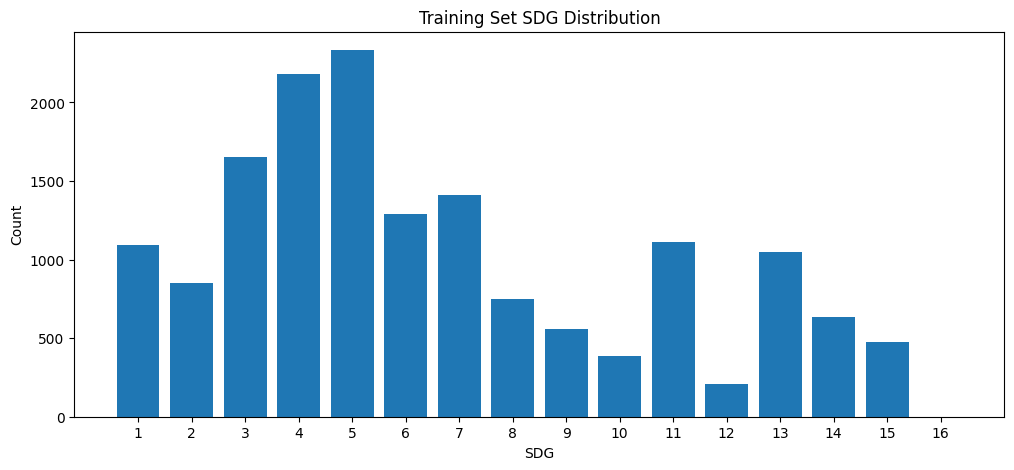

In [6]:
# =================================================================
# STEP 5: TRAIN-TEST SPLIT
# =================================================================
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
print(f"✓ Train: {len(split_dataset['train'])} samples")
print(f"✓ Test: {len(split_dataset['test'])} samples")

# Visualize distribution
def plot_distribution(dataset_split, title):
    # Count occurrences of each SDG
    counts = np.zeros(NUM_LABELS)
    for sample in dataset_split:
        for idx, val in enumerate(sample['labels']):
            counts[idx] += val
    
    plt.figure(figsize=(12, 5))
    plt.bar(range(1, NUM_LABELS + 1), counts)
    plt.xlabel('SDG')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(range(1, NUM_LABELS + 1))
    plt.show()

plot_distribution(split_dataset['train'], 'Training Set SDG Distribution')

In [7]:
# =================================================================
# STEP 6: TOKENIZATION
# =================================================================
MODEL_NAME = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    """Tokenize text and ensure labels are properly formatted."""
    tokenized = tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    # Convert labels to tensor format
    tokenized['labels'] = batch['labels']
    return tokenized

# Tokenize
tokenized_dataset = split_dataset.map(
    tokenize_batch, 
    batched=True,
    remove_columns=[col for col in split_dataset['train'].column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)

# Set format for PyTorch
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print("✓ Tokenization complete")
print(f"  Sample keys: {tokenized_dataset['train'][0].keys()}")

Map:   0%|          | 0/15984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

✓ Tokenization complete
  Sample keys: dict_keys(['labels', 'input_ids', 'attention_mask'])


In [8]:
# =================================================================
# STEP 7: MODEL INITIALIZATION (MULTI-LABEL)
# =================================================================
# Disable torch compile issues
torch.backends.optimized_for_inference = False
if hasattr(torch, '_dynamo'):
    torch._dynamo.config.suppress_errors = True

# Load model with multi-label configuration
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()},
    problem_type="multi_label_classification",  # KEY: This enables BCEWithLogitsLoss
).to(device)

print(f"✓ Model loaded on {device}")
print(f"  Problem type: {model.config.problem_type}")
print(f"  Number of labels: {model.config.num_labels}")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda
  Problem type: multi_label_classification
  Number of labels: 16


In [9]:
# =================================================================
# STEP 8: METRICS FOR MULTI-LABEL
# =================================================================
def compute_metrics(eval_pred):
    """
    Compute multi-label metrics.
    
    For multi-label, we apply sigmoid to logits and threshold at 0.5
    to get binary predictions for each label.
    """
    logits, labels = eval_pred
    
    # Apply sigmoid to get probabilities
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    
    # Threshold at 0.5 for predictions
    predictions = (probs > 0.5).astype(int)
    
    # Flatten for sklearn metrics
    labels_flat = labels.flatten()
    preds_flat = predictions.flatten()
    
    # Compute metrics
    f1_micro = f1_score(labels_flat, preds_flat, average='micro', zero_division=0)
    f1_macro = f1_score(labels_flat, preds_flat, average='macro', zero_division=0)
    f1_weighted = f1_score(labels_flat, preds_flat, average='weighted', zero_division=0)
    precision = precision_score(labels_flat, preds_flat, average='weighted', zero_division=0)
    recall = recall_score(labels_flat, preds_flat, average='weighted', zero_division=0)
    
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
    }

print("✓ Metrics function defined")

✓ Metrics function defined


In [10]:
# =================================================================
# STEP 9: TRAINING CONFIGURATION
# =================================================================
training_args = TrainingArguments(
    output_dir='./outputs',
    
    # Batch sizes
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # Effective batch size = 16
    
    # Learning rate & epochs
    learning_rate=2e-5,  # Slightly lower for stability
    num_train_epochs=3,
    warmup_ratio=0.1,  # 10% warmup
    
    # Evaluation & saving
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,
    
    # Logging
    logging_steps=50,
    logging_dir='./logs',
    report_to='none',
    
    # Performance
    fp16=True if device == 'cuda' else False,
    optim="adamw_torch_fused" if device == 'cuda' else "adamw_torch",
    
    # Misc
    seed=42,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

print("✓ Trainer configured")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

✓ Trainer configured
  Epochs: 3
  Batch size: 8
  Learning rate: 2e-05


In [11]:
# =================================================================
# STEP 10: TRAINING
# =================================================================
print("Starting training...")
print("="*50)

try:
    if device == 'cuda':
        torch.cuda.empty_cache()
    
    train_results = trainer.train()
    
    print("\n" + "="*50)
    print("✓ Training complete!")
    print(f"  Total steps: {train_results.global_step}")
    print(f"  Training loss: {train_results.training_loss:.4f}")
    
except Exception as e:
    print(f"\n❌ Error during training: {str(e)}")
    raise

Starting training...


W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708] WON'T CONVERT compiled_embeddings /opt/conda/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py line 207 
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708] due to: 
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708] Traceback (most recent call last):
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708]   File "/opt/conda/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1625, in __call__
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708]     result = self._inner_convert(
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708]              ^^^^^^^^^^^^^^^^^^^^
W1201 16:56:20.904000 331 site-packages/torch/_dynamo/convert_frame.py:1708]   File "/opt/conda/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 688, in __call__
W120

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Precision,Recall
1,0.127400,0.060225,0.981113,0.915142,0.980610,0.980471,0.981113
2,0.088900,0.058143,0.981640,0.918889,0.981314,0.981152,0.981640
3,0.047800,0.058808,0.981957,0.920179,0.981624,0.981468,0.981957



✓ Training complete!
  Total steps: 2997
  Training loss: 0.1261


In [12]:
# =================================================================
# STEP 11: EVALUATION
# =================================================================
print("Running final evaluation...")
eval_results = trainer.evaluate()

print("\n=== Evaluation Results ===")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Running final evaluation...



=== Evaluation Results ===
  eval_loss: 0.0588
  eval_f1_micro: 0.9820
  eval_f1_macro: 0.9202
  eval_f1_weighted: 0.9816
  eval_precision: 0.9815
  eval_recall: 0.9820
  eval_runtime: 5.3234
  eval_samples_per_second: 333.8080
  eval_steps_per_second: 21.0390
  epoch: 3.0000


In [13]:
# =================================================================
# STEP 12: SAVE MODEL
# =================================================================
OUTPUT_DIR = './final_model'

trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"✓ Model saved to {OUTPUT_DIR}/")
print(f"  Contents: {os.listdir(OUTPUT_DIR)}")

✓ Model saved to ./final_model/
  Contents: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.json']


In [14]:
# =================================================================
# STEP 13: TEST INFERENCE
# =================================================================
from transformers import pipeline

print("Testing inference...\n")

# For multi-label, we need a custom inference function
def predict_sdgs(text, model, tokenizer, threshold=0.5, top_k=3):
    """
    Predict SDGs for a given text.
    
    Returns top_k predictions with their confidence scores.
    """
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True, 
        max_length=512
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0]
        probs = torch.sigmoid(logits).cpu().numpy()
    
    # Get top-k predictions
    top_indices = np.argsort(probs)[::-1][:top_k]
    
    results = []
    for idx in top_indices:
        results.append({
            'label': model.config.id2label[idx],
            'score': float(probs[idx]),
            'above_threshold': probs[idx] >= threshold
        })
    
    return results

# Test samples
test_texts = [
    "Wind farm construction in rural communities provides clean renewable energy.",
    "Gender parity in university STEM programs helps reduce inequality.",
    "Sustainable aquaculture practices protect marine ecosystems.",
    "Access to clean drinking water and sanitation in developing nations.",
    "Reducing carbon emissions through electric vehicle adoption."
]

for text in test_texts:
    print(f"Text: {text[:60]}...")
    predictions = predict_sdgs(text, model, tokenizer)
    for pred in predictions:
        status = "✓" if pred['above_threshold'] else "○"
        print(f"  {status} {pred['label']}: {pred['score']:.2%}")
    print()

Testing inference...

Text: Wind farm construction in rural communities provides clean r...
  ✓ SDG 7: 99.08%
  ○ SDG 8: 0.72%
  ○ SDG 11: 0.64%

Text: Gender parity in university STEM programs helps reduce inequ...
  ✓ SDG 5: 58.54%
  ○ SDG 4: 4.39%
  ○ SDG 3: 2.75%

Text: Sustainable aquaculture practices protect marine ecosystems....
  ✓ SDG 14: 99.79%
  ○ SDG 15: 2.65%
  ○ SDG 6: 0.74%

Text: Access to clean drinking water and sanitation in developing ...
  ✓ SDG 6: 88.38%
  ○ SDG 3: 5.58%
  ○ SDG 2: 2.11%

Text: Reducing carbon emissions through electric vehicle adoption....
  ○ SDG 7: 40.09%
  ○ SDG 13: 5.99%
  ○ SDG 12: 1.62%



In [15]:
# =================================================================
# STEP 14: UPLOAD TO HUGGING FACE (OPTIONAL)
# =================================================================
# Uncomment and fill in to upload to Hugging Face Hub

# from huggingface_hub import login, HfApi
# 
# # Login (get token from https://huggingface.co/settings/tokens)
# login(token="YOUR_HF_TOKEN")
# 
# # Push to hub
# model.push_to_hub("your-username/sdg-classifier-multilabel")
# tokenizer.push_to_hub("your-username/sdg-classifier-multilabel")
# 
# print("✓ Uploaded to Hugging Face Hub!")

## Notes for Web App Integration

### Label Format
The model's `id2label` is configured as:
- `0`: "SDG 1"
- `1`: "SDG 2"
- ...
- `15`: "SDG 16"

### Multi-Label Output
- Scores are **independent** (don't sum to 1)
- Each score represents the probability that the text belongs to that SDG
- Multiple SDGs can have high scores simultaneously


### API Response Format
Gradio Space should return:
```python
{
    "SDG 1": 0.05,
    "SDG 2": 0.12,
    "SDG 3": 0.03,
    ...
    "SDG 7": 0.87,  # High confidence
    ...
}
```

In [19]:
from huggingface_hub import login, HfApi

# Login - get your token from https://huggingface.co/settings/tokens
# Make sure it has "write" permissions
login(token="HF_TOKEN_REMOVED")

# Push model and tokenizer to Hub
model.push_to_hub("SterlingWork/sdg-classifier-multilabel")
tokenizer.push_to_hub("SterlingWork/sdg-classifier-multilabel")

print("✓ Model uploaded!")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md: 0.00B [00:00, ?B/s]

✓ Model uploaded!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.5 MB/s eta 0:00:00
Generating predictions on test set...
✓ Generated predictions for 1777 samples

CLASSIFICATION REPORT (Per-SDG Performance)
SDG 1    | Precision: 0.816 | Recall: 0.727 | F1: 0.769 | Support:  110
SDG 2    | Precision: 0.890 | Recall: 0.786 | F1: 0.835 | Support:  103
SDG 3    | Precision: 0.958 | Recall: 0.946 | F1: 0.952 | Support:  167
SDG 4    | Precision: 0.925 | Recall: 0.910 | F1: 0.918 | Support:  245
SDG 5    | Precision: 0.923 | Recall: 0.857 | F1: 0.889 | Support:  252
SDG 6    | Precision: 0.879 | Recall: 0.867 | F1: 0.873 | Support:  143
SDG 7    | Precision: 0.981 | Recall: 0.835 | F1: 0.902 | Support:  188
SDG 8    | Precision: 0.605 | Recall: 0.598 | F1: 0.601 | Support:   87
SDG 9    | Precision: 0.875 | Recall: 0.636 | F1: 0.737 | Support:   77
SDG 10   | Precision: 0.615 | Recall: 0.356 | F1: 0.451 | Support:   45
SDG 11   | Precision: 0.853 | Recall: 0.823 | F1: 0.838 | Support:  113
SDG 

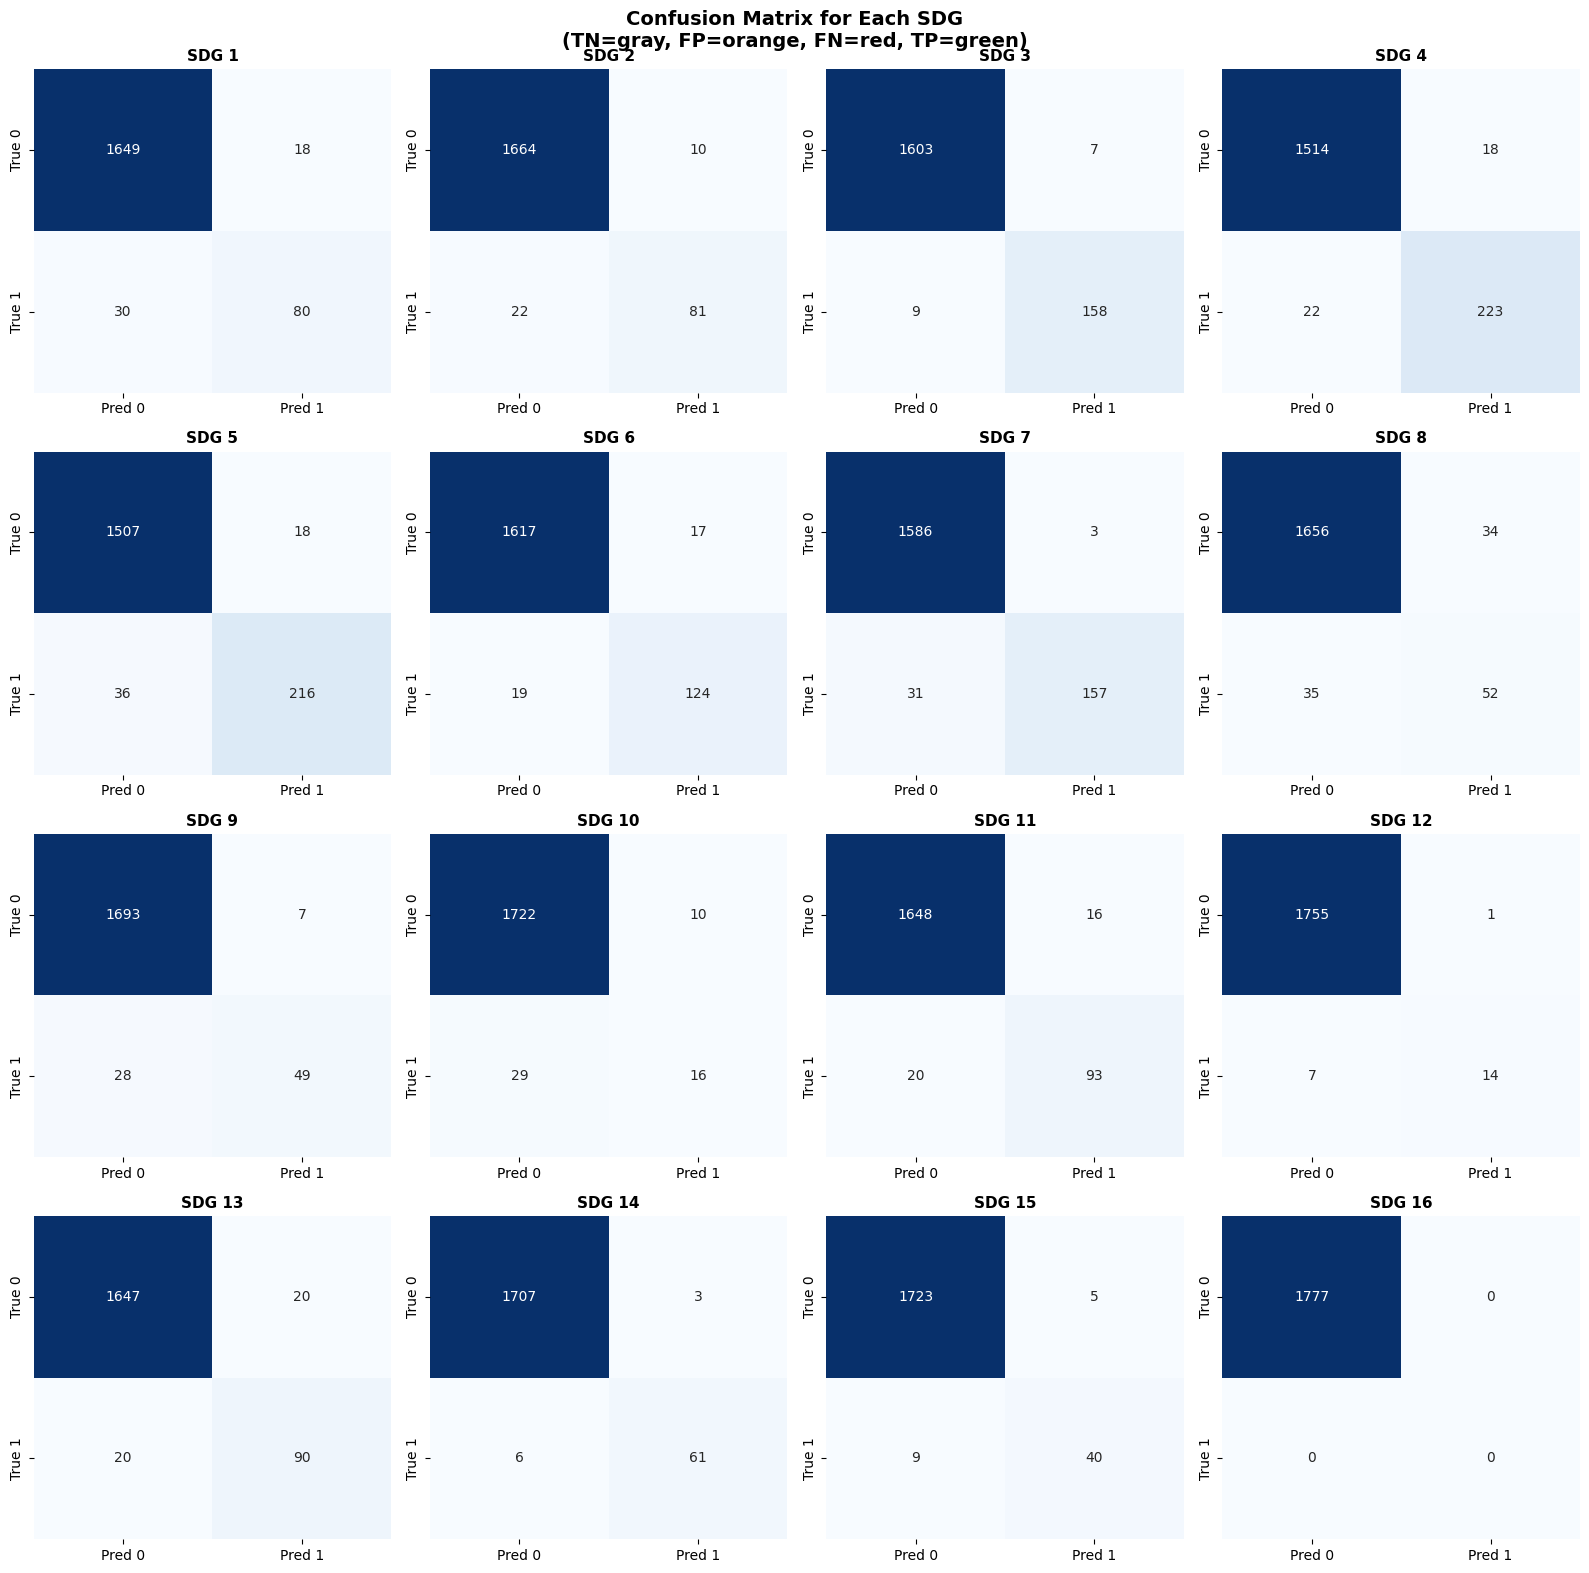

✓ Saved: confusion_matrices_all_sdgs.png

AGGREGATED CONFUSION MATRIX


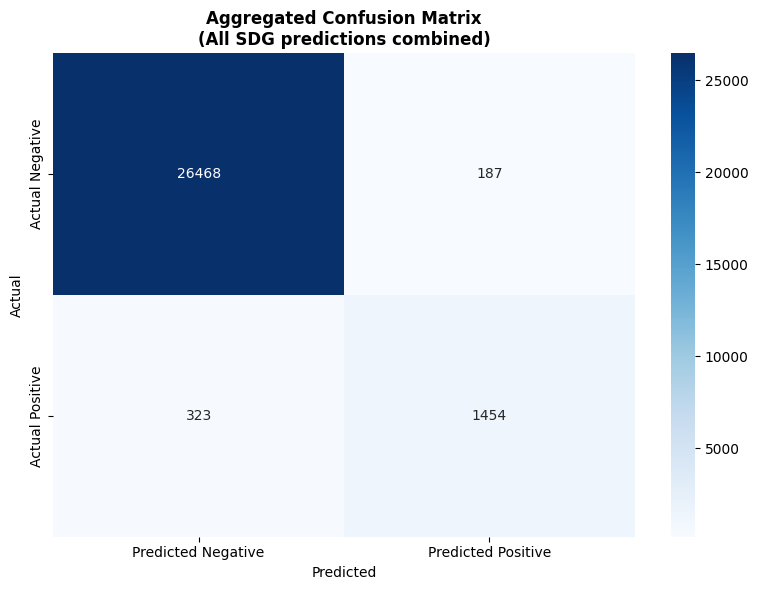


True Negatives:  26,468 (correctly predicted NOT this SDG)
False Positives: 187 (incorrectly predicted this SDG)
False Negatives: 323 (missed this SDG)
True Positives:  1,454 (correctly predicted this SDG)

Overall Metrics:
  Accuracy:  0.9821 (98.21%)
  Precision: 0.8860 (88.60%)
  Recall:    0.8182 (81.82%)
  F1 Score:  0.8508 (85.08%)

✓ Saved: confusion_matrix_aggregated.png

ERROR ANALYSIS - Most Confused SDG Pairs

Top 10 Confusion Pairs (True SDG → Incorrectly Predicted SDG):
--------------------------------------------------
  SDG  5 was confused with SDG  8: 9 times
  SDG 10 was confused with SDG  1: 9 times
  SDG  4 was confused with SDG  8: 7 times
  SDG  7 was confused with SDG 13: 7 times
  SDG  8 was confused with SDG  4: 7 times
  SDG 10 was confused with SDG  8: 7 times
  SDG  1 was confused with SDG 10: 6 times
  SDG  2 was confused with SDG 13: 5 times
  SDG  5 was confused with SDG  4: 5 times
  SDG  6 was confused with SDG 11: 4 times

CONFIDENCE DISTRIBUTION


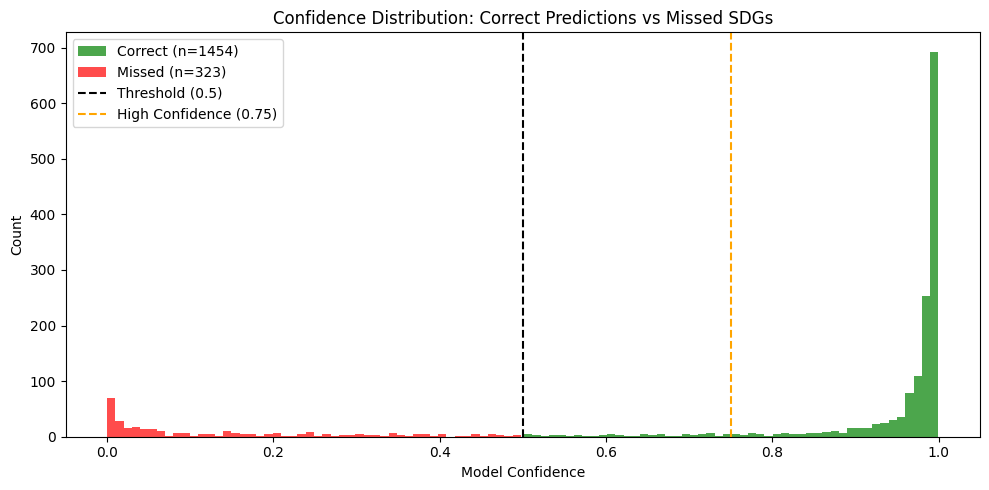

✓ Saved: confidence_distribution.png

ANALYSIS COMPLETE!


In [20]:
# =================================================================
# CONFUSION MATRIX VISUALIZATION FOR MULTI-LABEL SDG CLASSIFIER
# =================================================================
!pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import torch

# =================================================================
# STEP 1: GET PREDICTIONS ON TEST SET
# =================================================================
print("Generating predictions on test set...")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in torch.utils.data.DataLoader(tokenized_dataset['test'], batch_size=32):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].numpy()
        
        outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))  # sigmoid
        preds = (probs > 0.5).astype(int)
        
        all_preds.extend(preds)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"✓ Generated predictions for {len(all_preds)} samples")

# =================================================================
# STEP 2: CLASSIFICATION REPORT (Per-SDG metrics)
# =================================================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Per-SDG Performance)")
print("="*60)

sdg_names = [f"SDG {i}" for i in range(1, 17)]

# For multi-label, we need to handle this per-label
for i, sdg in enumerate(sdg_names):
    true_pos = np.sum((all_labels[:, i] == 1) & (all_preds[:, i] == 1))
    false_pos = np.sum((all_labels[:, i] == 0) & (all_preds[:, i] == 1))
    false_neg = np.sum((all_labels[:, i] == 1) & (all_preds[:, i] == 0))
    true_neg = np.sum((all_labels[:, i] == 0) & (all_preds[:, i] == 0))
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    support = np.sum(all_labels[:, i])
    
    print(f"{sdg:8} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Support: {int(support):4}")

# =================================================================
# STEP 3: MULTI-LABEL CONFUSION MATRICES (Small multiples)
# =================================================================
print("\n" + "="*60)
print("GENERATING CONFUSION MATRICES...")
print("="*60)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Confusion Matrix for Each SDG\n(TN=gray, FP=orange, FN=red, TP=green)', 
             fontsize=14, fontweight='bold')

mcm = multilabel_confusion_matrix(all_labels, all_preds)

for i, (ax, sdg) in enumerate(zip(axes.flat, sdg_names)):
    cm = mcm[i]
    
    # Custom colormap: TN=light, FP=orange, FN=red, TP=green
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                cbar=False)
    ax.set_title(sdg, fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig('confusion_matrices_all_sdgs.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrices_all_sdgs.png")

# =================================================================
# STEP 4: AGGREGATED CONFUSION MATRIX (Flattened view)
# =================================================================
# This treats all (sample, SDG) pairs as individual predictions

print("\n" + "="*60)
print("AGGREGATED CONFUSION MATRIX")
print("="*60)

flat_labels = all_labels.flatten()
flat_preds = all_preds.flatten()

cm_agg = confusion_matrix(flat_labels, flat_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_agg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Aggregated Confusion Matrix\n(All SDG predictions combined)', fontsize=12, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix_aggregated.png', dpi=150, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm_agg.ravel()
print(f"\nTrue Negatives:  {tn:,} (correctly predicted NOT this SDG)")
print(f"False Positives: {fp:,} (incorrectly predicted this SDG)")
print(f"False Negatives: {fn:,} (missed this SDG)")
print(f"True Positives:  {tp:,} (correctly predicted this SDG)")

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1 Score:  {f1:.4f} ({f1*100:.2f}%)")

print("\n✓ Saved: confusion_matrix_aggregated.png")

# =================================================================
# STEP 5: ERROR ANALYSIS - Most Common Mistakes
# =================================================================
print("\n" + "="*60)
print("ERROR ANALYSIS - Most Confused SDG Pairs")
print("="*60)

# Find cases where model predicted wrong SDG
errors = []
for sample_idx in range(len(all_labels)):
    true_sdgs = np.where(all_labels[sample_idx] == 1)[0]
    pred_sdgs = np.where(all_preds[sample_idx] == 1)[0]
    
    # False positives (predicted but shouldn't have)
    for pred_idx in pred_sdgs:
        if pred_idx not in true_sdgs:
            for true_idx in true_sdgs:
                errors.append((true_idx + 1, pred_idx + 1))  # +1 for SDG numbering

# Count error pairs
from collections import Counter
error_counts = Counter(errors)

print("\nTop 10 Confusion Pairs (True SDG → Incorrectly Predicted SDG):")
print("-" * 50)
for (true_sdg, pred_sdg), count in error_counts.most_common(10):
    print(f"  SDG {true_sdg:2} was confused with SDG {pred_sdg:2}: {count} times")

# =================================================================
# STEP 6: CONFIDENCE DISTRIBUTION
# =================================================================
print("\n" + "="*60)
print("CONFIDENCE DISTRIBUTION")
print("="*60)

# Get probability scores
all_probs = []
model.eval()
with torch.no_grad():
    for batch in torch.utils.data.DataLoader(tokenized_dataset['test'], batch_size=32):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# Plot confidence distribution for correct vs incorrect predictions
correct_confidences = []
incorrect_confidences = []

for i in range(len(all_labels)):
    for j in range(16):
        if all_labels[i, j] == 1:  # This is a true positive SDG
            if all_preds[i, j] == 1:
                correct_confidences.append(all_probs[i, j])
            else:
                incorrect_confidences.append(all_probs[i, j])

plt.figure(figsize=(10, 5))
plt.hist(correct_confidences, bins=50, alpha=0.7, label=f'Correct (n={len(correct_confidences)})', color='green')
plt.hist(incorrect_confidences, bins=50, alpha=0.7, label=f'Missed (n={len(incorrect_confidences)})', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.axvline(x=0.75, color='orange', linestyle='--', label='High Confidence (0.75)')
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct Predictions vs Missed SDGs')
plt.legend()
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: confidence_distribution.png")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)